I started importing all the libarires need to analize and to structured all the data acquired

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

#import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#!conda install -c districtdatalabs yellowbrick
#from yellowbrick.cluster import KElbowVisualizer
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

print('Libraries imported.')

Libraries imported.


First, we get the data of the latitude and longitude of each neighborhood, I get the information from the statisctial data website of Madrid, and I use and average of all coordinates points to get the center.

In [2]:

path_log_lat='https://raw.githubusercontent.com/Maurochin/Coursera_Capstone/master/Longitude-Latitude-%20Madrid.csv'
df_geo=pd.read_csv(path_log_lat,delimiter=";",error_bad_lines=False )
df_geo.columns=['Borough','Neighborhood','Longitude','Latitude']
df_geo.sort_values(by=['Neighborhood'],inplace=True)
df_geo.reset_index(inplace=True)
df_geo.drop(['index'],axis=1,inplace=True)
print(df_geo.shape)
df_geo.head()

(127, 4)


,Borough,Neighborhood,Longitude,Latitude
0,CARABANCHEL,ABRANTES,-3.7282,40.3808
1,ARGANZUELA,ACACIAS,-3.7062,40.4019
2,RETIRO,ADELFAS,-3.6711,40.4011
3,BARAJAS,AEROPUERTO,-3.5706,40.4548
4,BARAJAS,ALAMEDA DE OSUNA,-3.5901,40.4569


Then, we get the data of the average income by neighborhood. I get the data directly from the statistical website of Madrid city.

In [3]:
path_income='https://raw.githubusercontent.com/Maurochin/Coursera_Capstone/master/El_municipio_en_cifras_18_6_2020_12_31_10.csv'
df_income=pd.read_csv(path_income,sep=';',error_bad_lines=False)
df_income.drop(['Orden'],axis=1,inplace=True)
df_income.columns=['Borough code','Neighborhood','Average income']
df_income.head()

,Borough code,Neighborhood,Average income
0,28079BAR095,Valdemarin,112.321
1,28079BAR051,El Viso,103.573
2,28079BAR096,El Plantio,101.419
3,28079BAR082,Fuentelarreina,98.156
4,28079BAR162,Piovera,97.254


Then I realize what are the coordinates of Madrid city

In [4]:
address = 'Madrid'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinates of Madrid are {}, {}.'.format(latitude, longitude))


The geographical coordinates of Madrid are 40.4167047, -3.7035825.


Now, we plot every neighborhood in the map to see how are we dealing with the neighborhoods.

In [16]:
# create map of New York using latitude and longitude values
map_madrid = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_geo['Latitude'],df_geo['Longitude'], df_geo['Borough'], df_geo['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='white',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_madrid)  
    
map_madrid

I Define Forsquare Api Credentials

In [5]:
CLIENT_ID = 'LUIPNG11PH0TPDCNCYOSN42FDTFU0MWM1UPLZEJ11DIOUK1S' # your Foursquare ID
CLIENT_SECRET = '0BBNMPZ0IOCV4BCDKW5C2Q40YXPVVNQJDQJJMAD2A11FXAQR' # your Foursquare Secret
VERSION = '20200622' # Foursquare API version
LIMIT=1000
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LUIPNG11PH0TPDCNCYOSN42FDTFU0MWM1UPLZEJ11DIOUK1S
CLIENT_SECRET:0BBNMPZ0IOCV4BCDKW5C2Q40YXPVVNQJDQJJMAD2A11FXAQR


I get the info from Madrid coordinates to evaluate it.

In [6]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            latitude, 
            longitude, 
            1000, 
            LIMIT)
            
        # make the GET request
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ef79d5492654344bb4dd632'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Sol',
  'headerFullLocation': 'Sol, Madrid',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 231,
  'suggestedBounds': {'ne': {'lat': 40.42570470900001,
    'lng': -3.6917834416936883},
   'sw': {'lat': 40.407704690999985, 'lng': -3.7153815583063117}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda37f964a5201f3c21e3',
       'name': 'Puerta del Sol',
       'location': {'address': 'Pl. Puerta del Sol',
        'lat': 40.4170267569777,
        'lng': -3.703442763596807,
        'distance': 37,
        'postalCode': '28013',
        'cc': 'ES',
   

I get the Venues of the neighborhood, To do that I copy the function of the example

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

I call the function with Madrid neighborhood data to get all the venue data.

In [8]:
# type your answer here

t_venues = getNearbyVenues(names=df_geo['Neighborhood'],
                                   latitudes=df_geo['Latitude'],
                                   longitudes=df_geo['Longitude']
                                  )


ABRANTES
ACACIAS
ADELFAS
AEROPUERTO
ALAMEDA DE OSUNA
ALMAGRO
ALMENARA
ALMENDRALES
ALUCHE
AMPOSTA
APOSTOL SANTIAGO
ARAPILES
ARAVACA
ARCOS
ARGUELLES
ATALAYA
ATOCHA
BELLAS VISTAS
BERRUGUETE
BUENAVISTA
BUTARQUE
CAMPAMENTO
CANILLAS
CANILLEJAS
CASA DE CAMPO
CASCO HISTORICO DE BARAJAS
CASCO HISTORICO DE VALLECAS
CASCO HISTORICO DE VICALVARO
CASTELLANA
CASTILLA
CASTILLEJOS
CHOPERA
CIUDAD JARDIN
CIUDAD UNIVERSITARIA
COLINA
COMILLAS
CONCEPCION
CORRALEJOS
CORTES
COSTILLARES
CUATRO CAMINOS
CUATRO VIENTOS
DELICIAS
EL GOLOSO
EL PARDO
EL PLANTIO
EL VISO
EMBAJADORES
ENTREVIAS
ESTRELLA
FONTARRON
FUENTE DEL BERRO
FUENTELARREINA
GAZTAMBIDE
GOYA
GUINDALERA
HELLIN
HISPANOAMERICA
HORCAJO
IBIZA
IMPERIAL
JERONIMOS
JUSTICIA
LA PAZ
LAS AGUILAS
LEGAZPI
LISTA
LOS ANGELES
LOS CARMENES
LOS ROSALES
LUCERO
MARROQUINA
MEDIA LEGUA
MIRASIERRA
MOSCARDO
NINO JESUS
NUEVA ESPANA
NUMANCIA
OPANEL
ORCASITAS
ORCASUR
PACIFICO
PALACIO
PALOMAS
PALOMERAS BAJAS
PALOMERAS SURESTE
PALOS DE MOGUER
PAVONES
PENAGRANDE
PILAR
PINAR DEL REY

I check the size and the dataframe created

In [9]:
print(t_venues.shape)


t_venues.head(15)


(5861, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ABRANTES,40.3808,-3.7282,Parque Emperatriz María de Austria,40.377936,-3.721962,Park
1,ABRANTES,40.3808,-3.7282,La Piazzola,40.385917,-3.724067,Burger Joint
2,ABRANTES,40.3808,-3.7282,Burger King,40.381050,-3.728027,Fast Food Restaurant
3,ABRANTES,40.3808,-3.7282,Telepizza,40.381239,-3.728458,Pizza Place
4,ABRANTES,40.3808,-3.7282,Fitness Place Piscina Marbella,40.383232,-3.720717,Gym / Fitness Center
5,ABRANTES,40.3808,-3.7282,Migas,40.380106,-3.727942,Bakery
6,ABRANTES,40.3808,-3.7282,Campos de Futbol Ernesto Cotorruelo,40.380795,-3.724066,Soccer Field
7,ABRANTES,40.3808,-3.7282,Escuela Federacion Futbol Madrid . Campo Ernes...,40.380805,-3.723428,Athletics & Sports
8,ABRANTES,40.3808,-3.7282,La Ventura,40.386655,-3.728057,Nightclub
9,ABRANTES,40.3808,-3.7282,La Nueva Pocha,40.386409,-3.728038,Tapas Restaurant


Now we are going to count how many venues we have for each neighborhood

In [ ]:
#t_venues[['Neighborhood','Venue']].groupby('Neighborhood').count('Venue').plot(kind='hist',bins=5,color='blue')
#plt.hist(t_venues['Neighborhood#plt.hist(t_venues['Neighborhood'].unique(),t_venues['Venue'].count())'].unique(),t_venues['Venue'].count())
#plt.show()C
t_venues['Venue'].loc(:100).count()

Then we get the quantity of unique categories.

In [58]:
print('There are {} uniques categories.'.format(len(t_venues['Venue Category'].unique())))

There are 284 uniques categories.


I analize each neighborhood

In [59]:
# one hot encoding
t_onehot = pd.get_dummies(t_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
t_onehot['Neighborhood'] = t_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [t_onehot.columns[-1]] + list(t_onehot.columns[:-1])
t_onehot = t_onehot[fixed_columns]

t_onehot.head()

,Yoga Studio,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College & University,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Train Station,Travel Agency,Travel Lounge,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,0,0,0,

In [60]:
t_onehot.shape

(5861, 284)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [61]:
t_grouped = t_onehot.groupby('Neighborhood').mean().reset_index()
t_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Betting Shop,Big Box Store,Bistro,Board Shop,Boarding House,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Casino,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College & University,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community College,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Dive Shop,Dog Run,Donut Shop,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Electronics Store,Embassy / Consulate,Ethiopian Restaurant,Event Space,Exhibit,Fabric Shop,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lottery Retailer,Lounge,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Office,Opera House,Optical Shop,Other Event,Other Great Outdoors,Other Nightlife,Outdoors & Recreation,Paella Restaurant,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Resort,Restaurant,Road,Rock Club,Roof Deck,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Student Center,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Taverna,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Trade School,Trail,Train Station,Travel Agency,Travel Lounge,Udon Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store
0,ABRANT

In [62]:
t_grouped.shape

(127, 284)

I start to cluster the neighborhoods, I define 5 clusters

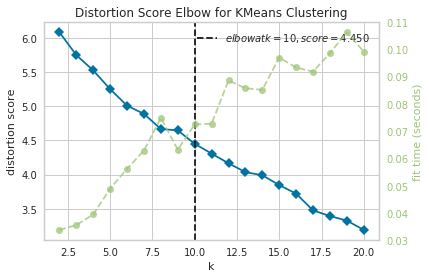

In [71]:
#we prepare our Xdata
t_grouped_clustering = t_grouped.drop('Neighborhood', 1)


model = KElbowVisualizer(KMeans(), k=20)
model.fit(t_grouped_clustering)
model.show()


Now that we get our best K=6, we create our Kmeans model

In [72]:
kclusters=10
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(t_grouped_clustering)
# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 5, 5, 1, 0, 0, 1, 7, 5, 3], dtype=int32)

Now let's create the new dataframe and display the top 10 venues for each neighborhood and a function to sort the venues in descending order.

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = t_grouped['Neighborhood']

for ind in np.arange(t_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(t_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABRANTES,Bakery,Park,Brazilian Restaurant,Burger Joint,Metro Station,Fast Food Restaurant,Nightclub,Tapas Restaurant,Athletics & Sports,Gym / Fitness Center
1,ACACIAS,Spanish Restaurant,Bar,Restaurant,Tapas Restaurant,Art Gallery,Gym / Fitness Center,Market,Indie Theater,Plaza,Pizza Place
2,ADELFAS,Spanish Restaurant,Bar,Grocery Store,Fast Food Restaurant,Gym,Supermarket,Pizza Place,Hotel,Sandwich Place,Bakery
3,AEROPUERTO,Restaurant,Airport Terminal,Road,Spanish Restaurant,BBQ Joint,Auto Garage,Bus Station,Paella Restaurant,Fabric Shop,Ethiopian Restaurant
4,ALAMEDA DE OSUNA,Hotel,Spanish Restaurant,Restaurant,Smoke Shop,Hotel Bar,Chinese Restaurant,Park,Metro Station,Garden,Fried Chicken Joint
5,ALMAGRO,Restaurant,Spanish Restaurant,Hotel,Tapas Restaurant,Bar,Plaza,Mediterranean Restaurant,French Restaurant,Coffee Shop,Japanese Restaurant
6,ALMENARA,Spanish Restaurant,Chinese Restaurant,Hotel,Gym / Fitness Center,Coffee Shop,Plaza,Italian Restaurant,Breakfast Spot,Restaurant,BBQ Joint
7,ALMENDRALES,Spanish Restaurant,Bar,Clothing Store,Seafood Restaurant,Fast Food Restaurant,Grocery Store,Restaurant,Chinese Restaurant,Bakery,Electronics Store
8,ALUCHE,Restaurant,Soccer Field,Park,Bar,Italian Restaurant,Shopping Mall,Bus Station,Brewery,Latin American Restaurant,Paella Restaurant
9,AMPOSTA,Park,Supermarket,Spanish Restaurant,Grocery Store,Gym,Steakhouse,Women's Store,Falafel Restaurant,Ethiopian Restaurant,Event Space



Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood

In [74]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

t_merged = df_geo

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
t_merged = t_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

t_merged.dropna(axis=0,inplace=True)# check the fillna(last columns!
t_merged.head()

,Borough,Neighborhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,CARABANCHEL,ABRANTES,-3.7282,40.3808,3,Bakery,Park,Brazilian Restaurant,Burger Joint,Metro Station,Fast Food Restaurant,Nightclub,Tapas Restaurant,Athletics & Sports,Gym / Fitness Center
1,ARGANZUELA,ACACIAS,-3.7062,40.4019,5,Spanish Restaurant,Bar,Restaurant,Tapas Restaurant,Art Gallery,Gym / Fitness Center,Market,Indie Theater,Plaza,Pizza Place
2,RETIRO,ADELFAS,-3.6711,40.4011,5,Spanish Restaurant,Bar,Grocery Store,Fast Food Restaurant,Gym,Supermarket,Pizza Place,Hotel,Sandwich Place,Bakery
3,BARAJAS,AEROPUERTO,-3.5706,40.4548,1,Restaurant,Airport Terminal,Road,Spanish Restaurant,BBQ Joint,Auto Garage,Bus Station,Paella Restaurant,Fabric Shop,Ethiopian Restaurant
4,BARAJAS,ALAMEDA DE OSUNA,-3.5901,40.4569,0,Hotel,Spanish Restaurant,Restaurant,Smoke Shop,Hotel Bar,Chinese Restaurant,Park,Metro Station,Garden,Fried Chicken Joint


Finally, let's visualize the resulting clusters

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


TypeError: show() got an unexpected keyword argument 'figsize'

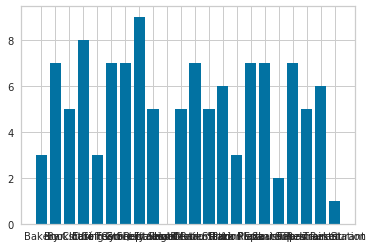

In [75]:
t_chart=t_merged[['Cluster Labels','1st Most Common Venue']]


#t_chart.count()

t_chart.sort_values(by=['1st Most Common Venue'],ascending=True , inplace=True)
#t_chart.plot(kind='bar',figsize=(100,20))

plt.bar(t_chart['1st Most Common Venue'],t_chart['Cluster Labels'])
plt.show(figsize=(100,20))
t_chart.head()
#.plot(kind='bar', figsize=(100, 60))

#plt.xlabel('Year') # add to x-label to the plot
#plt.ylabel('Number of immigrants') # add y-label to the plot
#plt.title('Icelandic immigrants to Canada from 1980 to 2013') # add title to the plot



In [79]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(t_merged['Latitude'], t_merged['Longitude'], t_merged['Neighborhood'], t_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=1).add_to(map_clusters)
    
       
map_clusters

In [21]:
t_merged.loc[t_merged['Cluster Labels'] == 0,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,CAMPAMENTO,Spanish Restaurant,Light Rail Station,Bus Station,Smoke Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand
41,CUATRO VIENTOS,Supermarket,Food & Drink Shop,Tapas Restaurant,Women's Store,Food Truck,Flower Shop,Food,Food Court,Food Stand,Football Stadium
44,EL PARDO,Spanish Restaurant,Mediterranean Restaurant,History Museum,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand
58,HORCAJO,Spanish Restaurant,Pizza Place,Park,Soccer Stadium,Soccer Field,Tapas Restaurant,Chinese Restaurant,Donut Shop,Flea Market,French Restaurant
59,IBIZA,Spanish Restaurant,Tapas Restaurant,Restaurant,Bakery,Seafood Restaurant,Italian Restaurant,Gastropub,Mediterranean Restaurant,Ice Cream Shop,Asian Restaurant
70,LUCERO,Pizza Place,Italian Restaurant,Spanish Restaurant,Fast Food Restaurant,Food & Drink Shop,Grocery Store,Supermarket,Asian Restaurant,Food Stand,Food
90,PINAR DEL REY,Supermarket,Spanish Restaurant,Pub,Metro Station,Tapas Restaurant,Soccer Field,Garden,Pizza Place,Brewery,Fountain
95,PUEBLO NUEVO,Bar,Spanish Restaurant,Brewery,Gym,Tapas Restaurant,Food Stand,Flower Shop,Food,Food & Drink Shop,Food Court
105,SAN DIEGO,Spanish Restaurant,Light Rail Station,Tapas Restaurant,Hotel,Italian Restaurant,Pizza Place,Music Venue,Pub,Supermarket,Restaurant
110,SANTA EUGENIA,Pizza Place,Bar,Spanish Restaurant,Supermarket,Tapas Restaurant,Mediterranean Restaurant,Gym,Soccer Field,Dumpling Restaurant,Eastern European Restaurant


In [23]:
t_merged.loc[t_merged['Cluster Labels'] == 1,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,AMPOSTA,Park,Spanish Restaurant,Music Venue,Snack Place,Metro Station,Supermarket,Food,Food Court,Flea Market,Flower Shop
48,ENTREVIAS,Bakery,Gym / Fitness Center,Park,Train Station,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court
68,LOS CARMENES,Stadium,Gym,Park,Café,Women's Store,Food Court,Flower Shop,Food,Food & Drink Shop,Food Stand
71,MARROQUINA,Park,Bakery,Metro Station,Women's Store,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand
104,SAN CRISTOBAL,Breakfast Spot,Metro Station,Park,Train Station,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand
117,VALDEFUENTES,Park,Skate Park,Women's Store,Food Court,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand,Fish & Chips Shop


In [24]:
t_merged.loc[t_merged['Cluster Labels'] == 2,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,APOSTOL SANTIAGO,Park,Grocery Store,Metro Station,Bakery,Pharmacy,Food Truck,Mediterranean Restaurant,Women's Store,Food & Drink Shop,Flower Shop
19,BUENAVISTA,Music School,Spanish Restaurant,Grocery Store,Metro Station,Gym,BBQ Joint,Gym / Fitness Center,Football Stadium,Food Truck,Flea Market
26,CASCO HISTORICO DE VALLECAS,Grocery Store,Gym,Food Truck,Women's Store,Food Court,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand
27,CASCO HISTORICO DE VICALVARO,Grocery Store,Spanish Restaurant,Pizza Place,Beer Bar,Ice Cream Shop,Playground,Convenience Store,Café,Food Court,Flower Shop
52,FUENTELARREINA,Fast Food Restaurant,Diner,Grocery Store,Hotel,Food Stand,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court
56,HELLIN,Bar,Grocery Store,Gym,Park,Spanish Restaurant,Fountain,Football Stadium,Food Truck,Food Stand,Fish Market
67,LOS ANGELES,Bar,Café,Grocery Store,Restaurant,Spanish Restaurant,French Restaurant,Fountain,Football Stadium,Food Truck,Food Stand
73,MIRASIERRA,Sports Club,Gym,Grocery Store,Convenience Store,Café,Women's Store,Food Court,Flower Shop,Food,Food & Drink Shop
78,OPANEL,Plaza,Coffee Shop,Grocery Store,Fast Food Restaurant,Gym / Fitness Center,Burger Joint,Library,Farmers Market,Bar,Bakery
79,ORCASITAS,Plaza,Grocery Store,Farmers Market,Sporting Goods Shop,French Restaurant,Fountain,Football Stadium,Food Truck,Food Stand,Fish & Chips Shop


In [25]:
t_merged.loc[t_merged['Cluster Labels'] == 3,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,PIOVERA,Cheese Shop,Women's Store,Fish Market,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain,Football Stadium,Food Truck


In [26]:
t_merged.loc[t_merged['Cluster Labels'] == 4,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABRANTES,Bakery,Restaurant,Gym / Fitness Center,Park,Athletics & Sports,Fast Food Restaurant,Soccer Field,Pizza Place,Football Stadium,Food Truck
1,ACACIAS,Spanish Restaurant,Bar,Tapas Restaurant,Café,Pizza Place,Park,Pub,Supermarket,Gym,Gym / Fitness Center
2,ADELFAS,Grocery Store,Supermarket,Spanish Restaurant,Fast Food Restaurant,Bar,Brewery,Tapas Restaurant,Gift Shop,Bookstore,Peruvian Restaurant
4,ALAMEDA DE OSUNA,Tapas Restaurant,Plaza,Bakery,Smoke Shop,Fried Chicken Joint,Scenic Lookout,Spanish Restaurant,Chinese Restaurant,Bookstore,Bistro
5,ALMAGRO,Spanish Restaurant,Restaurant,Bar,Japanese Restaurant,Mediterranean Restaurant,French Restaurant,Coffee Shop,Italian Restaurant,Bookstore,Gastropub
6,ALMENARA,Chinese Restaurant,Japanese Restaurant,Library,Flea Market,Seafood Restaurant,Sandwich Place,Gym / Fitness Center,Martial Arts Dojo,BBQ Joint,Restaurant
7,ALMENDRALES,Spanish Restaurant,Seafood Restaurant,Gym,BBQ Joint,Pub,Restaurant,Fast Food Restaurant,Chinese Restaurant,Noodle House,Nightclub
8,ALUCHE,Italian Restaurant,Pizza Place,Restaurant,Diner,Bus Station,Bar,Paella Restaurant,Park,Brewery,Pie Shop
11,ARAPILES,Spanish Restaurant,Bakery,Café,Bar,Burrito Place,Sandwich Place,Supermarket,Restaurant,Theater,Italian Restaurant
12,ARAVACA,Restaurant,Italian Restaurant,Athletics & Sports,Grocery Store,Food Court,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand


In [27]:
t_merged.loc[t_merged['Cluster Labels'] == 5,t_merged.columns[[1] + list(range(5, t_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
33,CIUDAD UNIVERSITARIA,Bar,Park,Other Nightlife,Food Court,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Stand,Fish & Chips Shop
92,PORTAZGO,Bar,Gym / Fitness Center,Spanish Restaurant,Diner,Discount Store,Fruit & Vegetable Store,Frozen Yogurt Shop,Fried Chicken Joint,French Restaurant,Fountain


In [73]:
table = pd.pivot_table(t_merged,values='Latitude', columns='Cluster Labels', index='1st Most Common Venue',fill_value='0',aggfunc='count')
table

Cluster Labels,0.0,1.0,2.0,3.0,4.0,5.0
1st Most Common Venue,,,,,,
Bakery,0,1,0,0,2,0
Bar,1,0,2,0,2,2
Breakfast Spot,0,1,0,0,1,0
Café,0,0,0,0,3,0
Cheese Shop,0,0,0,1,0,0
Chinese Restaurant,0,0,0,0,2,0
Concert Hall,0,0,0,0,1,0
Department Store,0,0,0,0,1,0
Fast Food Restaurant,0,0,1,0,3,0


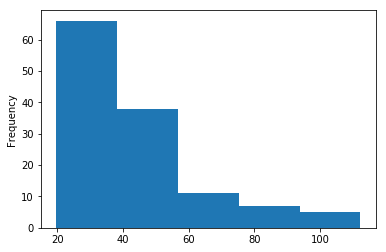

In [83]:
df_income['Average income'].plot(kind='hist',stacked=True,bins=5)